In [85]:
print(range(1,5)[1])

2


In [490]:
import numpy as np
from collections import Counter
def stochastic_round(x):
    x = np.asarray(x)
    floor_x = np.floor(x)
    prob = x - floor_x
    return floor_x + (np.random.rand(*x.shape) < prob)
class ability:
    def __init__(self, consumption, product_time, pop, status, prices, wealth):
        self.consumption = np.array(consumption, dtype=float)
        self.product_time = product_time
class TradeBlock(ability):
    def __init__(self, consumption, pop, product_time, status, prices, wealth):
        """
        经济模拟系统中的有贸易区块类。
        """
        # 读取参数，状态和工作时间
        super().__init__(consumption, product_time, pop, status, prices, wealth)
        self.pop = np.array(pop, dtype=float) # 集体的库存
        self.status = np.array(status, dtype=float) # 集体的库存
        self.prices = np.array(prices, dtype=float) # 商品的市场价格
        self.wealth = np.array(wealth, dtype=float) # 各职业手中的货币
        
        self.n = len(self.pop)
        self.status_hist = []
        self.last_diff = 0.001
        self.pop_last = self.pop+0
    def evol_Produce(self):
        """
        经济演化过程的生产与统一收购

        """
        # 计算各职业储蓄目标
        self.save_aim = 10 * (self.consumption * self.prices).sum(axis = 1)

        # 计算各职业每日工作时长 #
        # 个人财富= 总财富 / 相应阶级人口
        self.per_wealth = self.wealth / self.pop
        # 满意度 = 个人财富 / 储蓄目标 （满意度为 1 时开始不再全天工作）
        self.satisfy = self.per_wealth / self.save_aim
        # 工作时长 = exp(1 - 满意度)，且上限为1
        self.worktime = np.exp((1 - self.satisfy))
        self.worktime[self.worktime > 1] = 1
        self.worktime = np.round(self.worktime,2)

        # 计算各职业每日生产量 = 工作时长 / 生产单位商品所需时间
        self.production = self.pop * np.round(self.worktime / self.product_time,2)
    def evol_Levy(self):
        """
        经济演化过程收购

        """
        # 出售所得货币量 = 生产量 × 产品价格
        self.soldvalue = np.round(self.production * self.prices,2)
        # (待出售的)新状态 = 旧状态 + 产量
        self.status = self.status + self.production

        # 计算各职业新的财富状态 #
        # 所有商品（包括货币）统一进入仓库，并结算货款（可贷款）
        self.status[0] = self.status[0] - sum(self.soldvalue)
        self.wealth = self.wealth + self.soldvalue
    def evol_Consume(self):
        """
        经济演化过程的本地销售与消费

        """
        for j in range(self.n): # 从第 j 种商品开始依次购买
            for i in range(self.n): # 从第 i 个阶级开始依次购买
                new_status = self.status[j] - self.consumption[i,j] * self.pop[i]
                new_wealth = self.wealth[i] - self.consumption[i,j] * self.pop[i] * self.prices[j]
#                 print("test",new_status,new_wealth, i)
                if new_status > 0 and (new_wealth > 0 or i == 0): 
                # 如果库存足够消费，且该阶级存款足够/是统治阶级，则进行交易
                    self.status[j] = new_status
                    self.wealth[i] = new_wealth
                    self.status[0] += self.consumption[i,j] * self.prices[j]
                    if j == 0:
                        # 上税时回收货币到统治阶级手中
                        self.status[0] += self.consumption[i,j] * self.prices[j]
    def evol_Adjust(self):
        """
        经济演化后根据库存量调整商品价格，并处理转职

        """
        # 单位时间生产效率 = 商品价格 / 单位产品所需时间
        self.eff = self.prices / self.product_time
        # 不同职业间的效率差额
        self.diff = (self.eff[:, None] - self.eff[None, :])/self.eff
        # 只取出走者部分，入职部分 后续会通过 转置相减(反对称化) 得到
        self.diff[self.diff < 0] = 0
        # 出走人数 正比于 出走职业人数
#         self.diff = 50*((self.diff * (self.pop-1) * np.exp(1 - self.pop_last / self.pop) / sum(self.pop)).T).T  
        self.diff = 50*((self.diff * (self.pop-1) / sum(self.pop)).T).T  
        self.diff -= 0.5 * self.last_diff
        self.last_diff = self.diff + 0
        self.diff = stochastic_round(self.diff)
        r = 0.01 
#         self.pop_last = self.pop * r + self.pop_last * (1-r)
#         print(self.diff)
        # 出走者的财富 即 该阶级的 人均财富
        self.dif_wealth = self.diff * self.per_wealth
        self.dif_wealth -= self.dif_wealth.T
        self.wealth -= self.dif_wealth.sum(axis = 0)
        # 转置相减(反对称化)
        self.diff -= self.diff.T
        self.pop -= self.diff.sum(axis = 0)
        # 计算库存目标(货币不计) = 各项消耗 × 对应阶级人口 并对各阶级求和得到某项商品总消耗
        self.product_aim = 10 * (self.consumption.T * self.pop).sum(axis = 1)[1:]
        # 计算爆仓焦虑 = （库存 - 库存期望）/（库存 + 库存期望）
        self.urg_storage = (self.status[1:] - self.product_aim) / (self.status[1:] + self.product_aim)
        # 计算供需焦虑 =（生产量 - 预估消耗量）/（生产量 + 预估消耗量）
        self.est = (self.consumption.T * self.pop).sum(axis = 1)
        self.urg_supply = (self.production - self.est) / (self.est + self.production)
        # 计算新价格 = 原价格 × exp(爆仓焦虑+供需焦虑)
        self.prices[1:] = self.prices[1:] * np.exp(- .2 * self.urg_storage - 0.2 * self.urg_supply[1:])
        # 根据货币供给(市场当前货币量)进行补偿调整，防止价格同步上涨获取货币收益过低
        self.prices[1:] = np.round(self.prices[1:] * np.exp(0 * self.status[0] / sum(self.pop)),3)
        self.prices[self.prices > 100] = 100
        self.prices[self.prices < .01] = .01
    def recorder(self, show):
        if show != 0:
            print("status",self.status)
            print("prices",self.prices)
            print("eff",self.eff)
            print("wealth",self.wealth)
            print("pop",self.pop)
            print("pre_wealth",self.per_wealth)
            print("work_time",self.worktime)
            print("save_aim",self.save_aim)
            print("product_aim",self.product_aim)
    def evolution(self, show):
        self.evol_Produce()
        self.evol_Levy()
        self.evol_Consume()
        self.evol_Adjust()
        self.recorder(show)
        
test = TradeBlock(
[[0,1,1],[.1,1,1],[.1,1,1]],#consumption
[20,200,80],#pop
[1,0.5,0.2],#product time
[0,0,0],#status(storage)
[1,.5,.2],#prices
[0, 0, 0])#wealth

In [497]:
pop = []
prices = []
for i in range(50):
    test.evolution(0)
    pop.append(test.pop+0)
    prices.append(test.prices+0)
#     print(test.pop,test.prices,test.per_wealth)
#     print(test.save_aim,test.status, test.product_aim, test.worktime)

C:\Users\HASEE\AppData\Local\Temp\ipykernel_16500\1029271003.py:38: RuntimeWarning: divide by zero encountered in divide
  self.per_wealth = self.wealth / self.pop
C:\Users\HASEE\AppData\Local\Temp\ipykernel_16500\1029271003.py:101: RuntimeWarning: invalid value encountered in multiply
  self.dif_wealth = self.diff * self.per_wealth


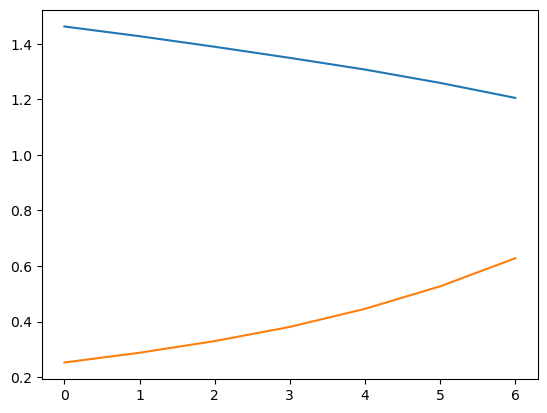

In [498]:
plt.plot(range(len(pop)),np.array(prices)[:,1])
plt.plot(range(len(pop)),np.array(prices)[:,2])

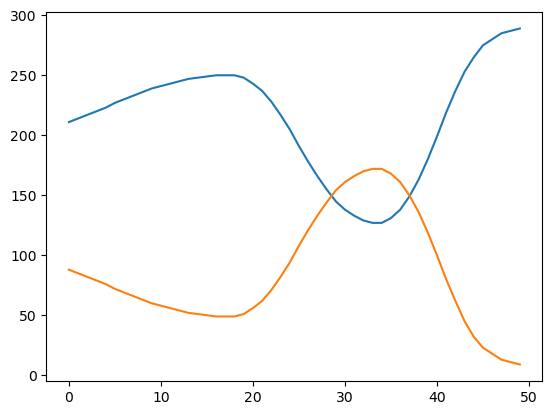

In [496]:
plt.plot(range(len(pop)),np.array(pop)[:,1])
plt.plot(range(len(pop)),np.array(pop)[:,2])

In [133]:
np.array([1,2]) @ np.array([[1,2],[3,4]]) 

array([ 7, 10])

In [445]:
(np.array([1,2])) * np.array([[1,2],[3,4]])

array([[1, 4],
       [3, 8]])

In [533]:
np.array([[1,2],[3,4]]).sum(axis = 1)

array([3, 7])

In [406]:
test.wealth

array([ 7513.7 , 19615.44, 32223.37])

In [351]:
test.status

array([-56256.22,   3150.2 ,   9538.1 ])

In [349]:
test.pop

array([114., 136.,   0.])

In [352]:
test.eff

array([10.        , 14.19746356,  1.05120469])

In [288]:
test.product_aim

array([2530., 2530.])

In [276]:
test.consumption

array([[0. , 2. , 2. ],
       [0.2, 1. , 1. ],
       [0.2, 1. , 1. ]])

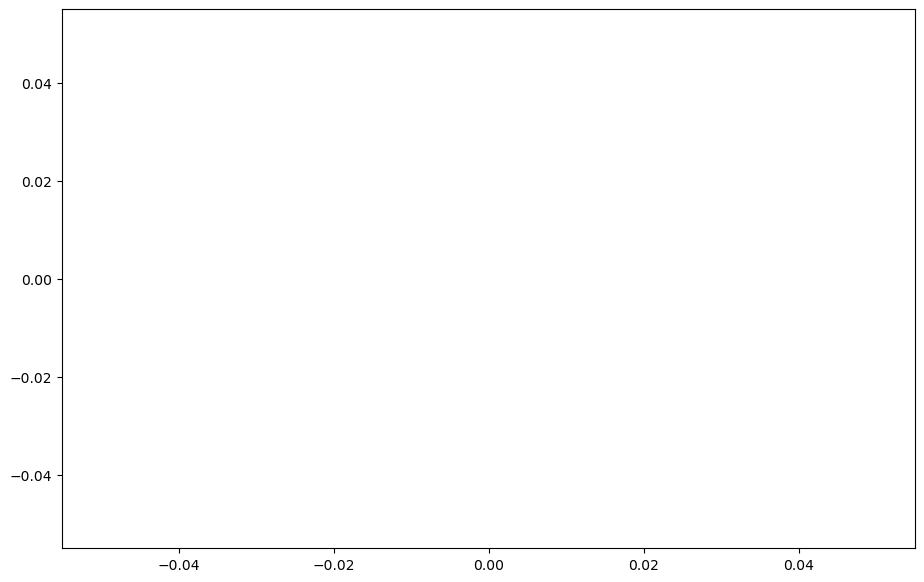

In [338]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

def visual(block):
    fig = plt.figure(figsize=(11, 7))
    gs = gridspec.GridSpec(2, 3, height_ratios=[1.2, 1])  # 上1行，下1行，比例2:1
    plt.plot()
visual(1)

In [220]:
a = np.array([[1,1],[0,1]]) * np.array([[1.2,-2.5],[3,4]])
a[a>3] = 5
a/np.array([5,10])

array([[ 0.24, -0.25],
       [ 0.  ,  0.5 ]])

In [221]:
a

array([[ 1.2, -2.5],
       [ 0. ,  5. ]])

In [218]:
def stochastic_round(x):
    x = np.asarray(x)
    floor_x = np.floor(x)
    prob = x - floor_x
    return floor_x + (np.random.rand(*x.shape) < prob)
stochastic_round([2.4,3.9])

array([2., 4.])

In [193]:
import numpy as np

A = np.array([
    [1, 2, 3],
    [4, 5, 6]
])

L = A.tolist()

print(L)


[[1, 2, 3], [4, 5, 6]]


In [194]:
a = []
a.append((np.array([[1,2],[3,4]])).tolist())
a

[[[1, 2], [3, 4]]]

In [159]:
test.wealth / test.pop

array([0., 0., 0.])

In [161]:
test.save_aim

AttributeError: 'TradeBlock' object has no attribute 'save_aim'

In [134]:
test.worktime

array([1., 1., 1.])

In [135]:
test.satisfy

array([0., 0., 0.])

In [136]:
test.pop

array([ 2., 15.,  8.])

In [137]:
test.daily_consumption

array([ 0., 12., 19.])

In [138]:
test.daily_cost

array([10.,  3.,  2.])

In [139]:
test.soldvalue

array([  2.,  60., 120.])

In [140]:
test.production

array([ 2., 30., 40.])

In [141]:
test.wealth

array([-178.,   60.,  120.])

In [142]:
test.product_aim

array([500., 250.])

In [144]:
test.per_wealth

array([-89.,   4.,  15.])